# Part II: Autoencoders for Anomaly Detection [30 pts]


## Step 1: Data preparation

1. Dataset: Numenta Anomaly Benchmark (NAB) > realAdExchange > exchange-2_cpm_results.csv
    - Dataset Link: https://www.kaggle.com/datasets/boltzmannbrain/nab
    - Description: This dataset is part of the Numenta Anomaly Benchmark (NAB) and belongs to the realAdExchange category in the exchange-2_cpm_results file. It consists of time series data collected from real advertising exchange where the primary metric recorded is cost per minute. The dataset has timestamps and corresponding numerical values that represent the CPM over time.

2. Analyze the dataset and provide the following statistics:
   - Number of samples (time points)
   - Number of features
   - Mean, standard deviation, minimum, and maximum values for each feature (or relevant descriptive statistics depending on the data type)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import LinearSegmentedColormap
from torch.utils.tensorboard.writer import SummaryWriter
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torchinfo import summary


df = pd.read_csv('exchange-2_cpm_results.csv')
print(df.shape)
print("----------------------------------------")
print(df.head())
print("----------------------------------------")
print(df['timestamp'].sample(5, random_state=42))
print("----------------------------------------")
print(df['value'].describe())
print("----------------------------------------")
print(df['timestamp'].describe())
print("----------------------------------------")
print(f"The number of features: {df.shape[1]}")



(1624, 2)
----------------------------------------
             timestamp     value
0  2011-07-01 00:00:01  0.401048
1  2011-07-01 01:00:01  0.392719
2  2011-07-01 02:00:01  0.309996
3  2011-07-01 03:00:01  0.212939
4  2011-07-01 04:00:01  0.205801
----------------------------------------
135     2011-07-06 15:00:01
481     2011-07-21 01:00:01
836     2011-08-04 21:00:01
1226    2011-08-21 07:00:01
629     2011-07-27 06:00:01
Name: timestamp, dtype: object
----------------------------------------
count    1624.000000
mean        0.336523
std         0.162187
min         0.000385
25%         0.208210
50%         0.295056
75%         0.456151
max         1.051442
Name: value, dtype: float64
----------------------------------------
count                    1624
unique                   1623
top       2011-08-24 12:00:01
freq                        2
Name: timestamp, dtype: object
----------------------------------------
The number of features: 2


3-1. Visualization 1: This graph shows a time series plot of the value feature over time by using shaded line shape. The x axis represents the timestamp and the y-axis indicates the corresponding value. It provides a clear overview of how the metric changes over the given time.

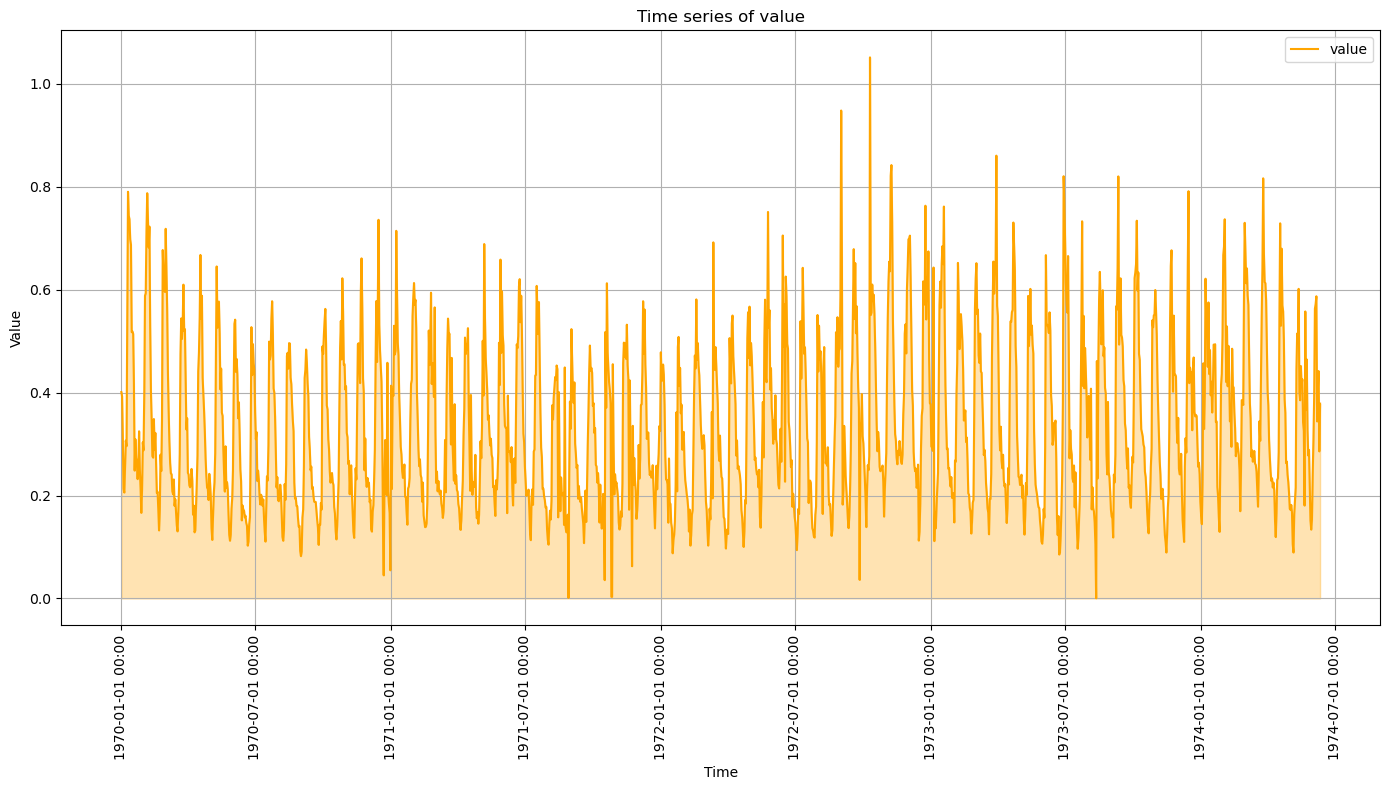

In [ ]:
plt.figure(figsize = (14, 8))
plt.plot(df['timestamp'], df['value'], color = 'orange', label = 'value')
plt.fill_between(df['timestamp'], df['value'], color = 'orange', alpha = 0.3)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation = 90)
plt.title('Time series of value')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


3-2. Visualization 2: The boxplot displays the distribution of the value feature to highlight the median meaning the horizontal line within the box, interquartile range meaning the box, and potential outliers. It provides a concise overview of the spread and outliers of the data.

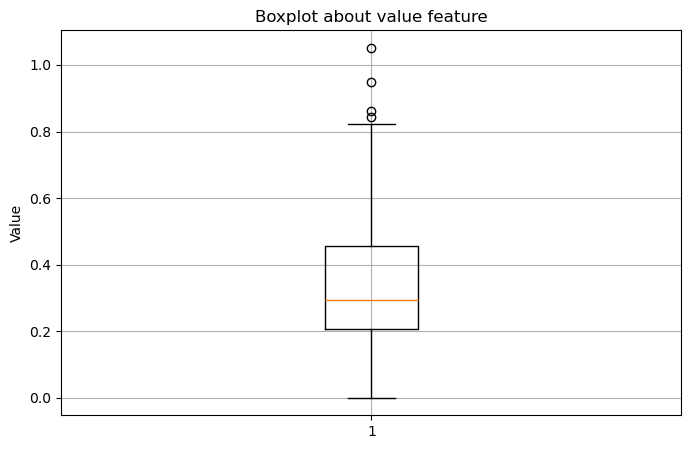

In [ ]:
plt.figure(figsize=(8, 5))
plt.boxplot(df['value'], vert=True)
plt.title('Boxplot about value feature')
plt.ylabel('Value')
plt.grid(True)
plt.show()


3-3. Visualization 3: This histogram explains the frequency distribution of the value feature. Most data points lie between 0.1 and 0.4. This line chart shows how the value feature varies by hour. It reveals a clear pattern where the average value tends to be lowest in the early morning and rises to a peak around mid day or early afternoon.

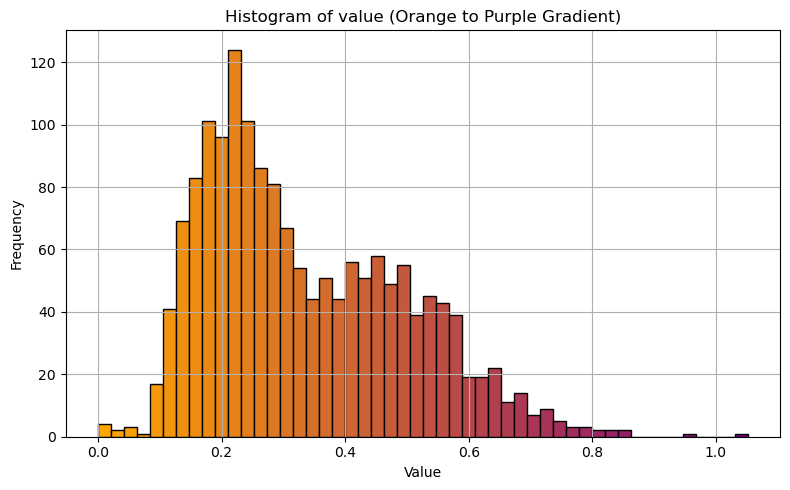

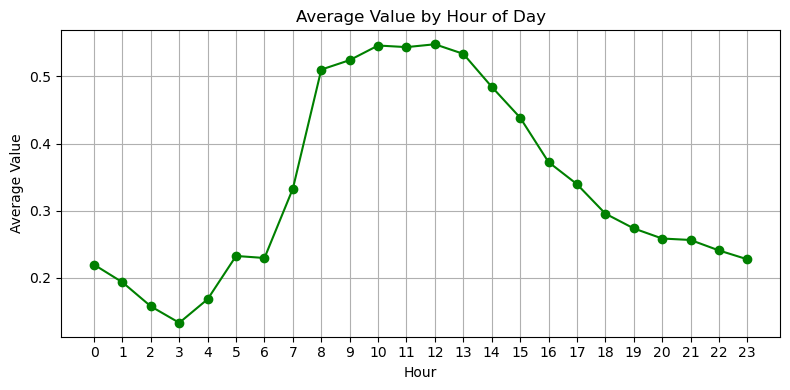

In [ ]:
counts, bins = np.histogram(df['value'], bins=50)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
orange_purple_cmap = LinearSegmentedColormap.from_list("orange_purple", ["#FFA500", "#800080"], N=len(bin_centers))
colors = orange_purple_cmap(np.linspace(0, 1, len(bin_centers)))

plt.figure(figsize=(8, 5))
for i in range(len(bin_centers)):
    plt.bar(bin_centers[i], counts[i], width=(bins[1]-bins[0]), color=colors[i], edgecolor='black')
plt.title('Histogram of value (Orange to Purple Gradient)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------------------------------------------------------------


df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour.astype(int)
hourly_avg = df.groupby('hour')['value'].mean()

plt.figure(figsize = (8, 4))
plt.plot(hourly_avg.index.to_numpy(), hourly_avg.to_numpy(), marker='o', color = 'green')
plt.title('Average Value by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Average Value')
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()



4. Identify any missing values -> There are no any missing values in the dataset.

In [ ]:
missing_counts = df.isnull().sum()
missing_ratio = missing_counts / len(df) * 100
print(pd.concat([missing_counts, missing_ratio], axis=1, keys=['Missing Count', 'Missing Ratio (%)']))

           Missing Count  Missing Ratio (%)
timestamp              0                0.0
value                  0                0.0
hour                   0                0.0


5. Preprocessing the dataset.

5-a. Normalize the data.
- MinMax scaling to the value column is used for creating a new value_norm that ranges between from 0 to 1 and for preserving the original shape of the data.
- The first plot compares hourly averages of the raw and normalized values showing a similar overall pattern.
- The second plot indicates the original and normalized time series at the same time. This confirms that the normalization keeps the same trends but compresses the data into a little bit smaller numerical range.

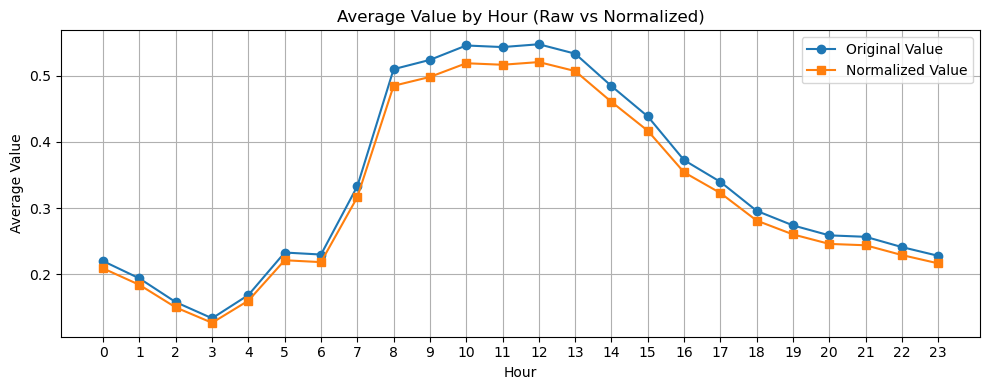

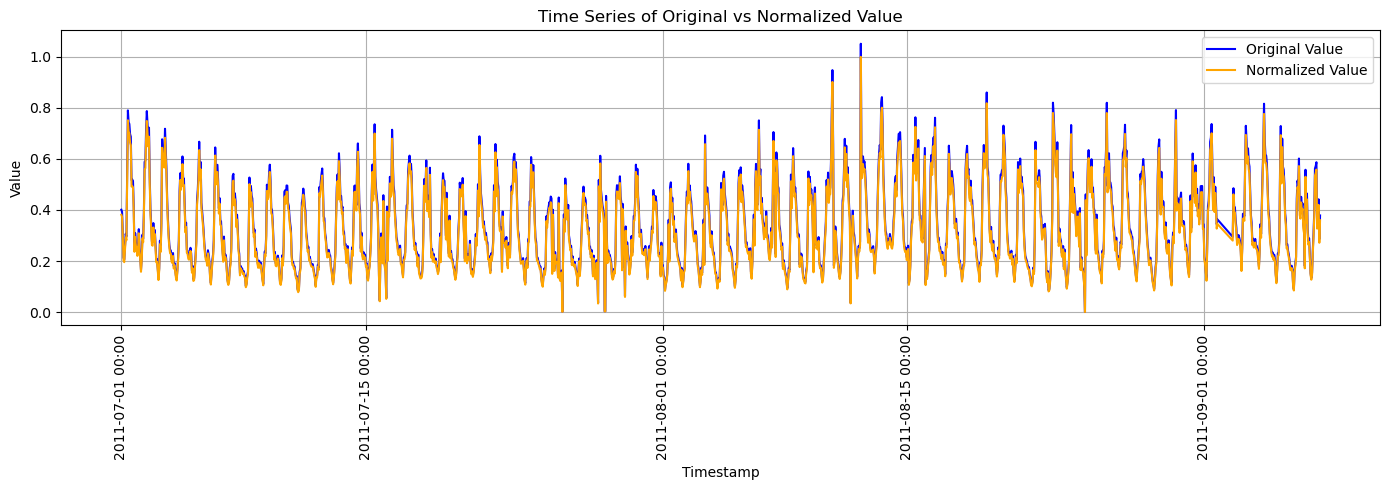

In [ ]:
scaler = MinMaxScaler()
df['normalized_value'] = scaler.fit_transform(df[['value']])
hourly_avg_raw = df.groupby('hour')['value'].mean()
hourly_avg_norm = df.groupby('hour')['normalized_value'].mean()

x_raw = hourly_avg_raw.index.to_numpy(dtype=int)
y_raw = hourly_avg_raw.to_numpy(dtype=float)
x_norm = hourly_avg_norm.index.to_numpy(dtype=int)
y_norm = hourly_avg_norm.to_numpy(dtype=float)

# --------------------------------------------------------------------------

plt.figure(figsize = (10, 4))
plt.plot(x_raw, y_raw, marker='o', label='Original Value')
plt.plot(x_norm, y_norm, marker='s', label='Normalized Value')

plt.title('Average Value by Hour (Raw vs Normalized)')
plt.xlabel('Hour')
plt.ylabel('Average Value')
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()
# --------------------------------------------------------------------------

plt.figure(figsize = (14, 5))

plt.plot(df['timestamp'], df['value'], color = 'blue', label = 'Original Value')
plt.plot(df['timestamp'], df['normalized_value'], color = 'orange', label = 'Normalized Value')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

plt.xticks(rotation = 90)
plt.title('Time Series of Original vs Normalized Value')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


5-b. Addressing class imbalance in the target column -> I don't need it

5-c. Converting target variable needs to numerical format: This is not required for my dataset because this dataset has only value and hour with numerical.

6. Spliting the dataset into training, testing and validation sets
    - This step defines a WINDOW_SIZE with 24 so that each input sequence spans 24 time steps
    - These sequences are split into training with 80%, validation with 10%, and testing with 10% by slicing the array.

In [ ]:
values = df['normalized_value'].values.astype(np.float32)
WINDOW_SIZE = 24

def create_sequences(data, window_size = 24):
    sequences = []

    for i in range(len(data) - window_size):
        seq = data[i : i + window_size]
        sequences.append(seq)

    return np.array(sequences)

all_sequences = create_sequences(values, WINDOW_SIZE)
all_sequences = np.expand_dims(all_sequences, axis = -1)

N = len(all_sequences)
train_end = int(N * 0.8)
val_end = int(N * 0.9)
train_data = all_sequences[:train_end]
val_data = all_sequences[train_end:val_end]
test_data = all_sequences[val_end:]

print("train_data:", train_data.shape)
print("val_data:", val_data.shape)
print("test_data:", test_data.shape)

class SequenceDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        return x, x

train_dataset = SequenceDataset(train_data)
val_dataset = SequenceDataset(val_data)
test_dataset= SequenceDataset(test_data)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

train_data: (1280, 24, 1)
val_data: (160, 24, 1)
test_data: (160, 24, 1)


## Step 2: Autoencoder model building

### Model 1 - Fully Connected Autoencoder ###

This architecture is a fully connected autoencoder that compresses a input with 24 dimensions into a 8 dimensional latent space and then reconstructs it back to 24 dimensions. The encoder has two linear layers from 24 to 16 or from 16 to 8 with Relu activation and a dropout layer in between. The decoder reverses this process using two linear layers from 8 to 16 and from 16 to 24 to include a dropout layer. It ends with a Sigmoid activation for the final output.

In [ ]:
class FCN_Autoencoder(nn.Module):
    def __init__(self, input_dimension = 24, latent_dimension = 8, dropout_value = 0.2):
        super(FCN_Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dimension, 16),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.Linear(16, latent_dimension),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dimension, 16),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.Linear(16, input_dimension),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        z = self.encoder(x)
        out = self.decoder(z)
        out = out.view(batch_size, -1, 1)
        return out

model_fcn = FCN_Autoencoder(input_dimension = WINDOW_SIZE, latent_dimension = 8, dropout_value = 0.2)
summary(model_fcn, input_size = (BATCH_SIZE, WINDOW_SIZE, 1))


Layer (type:depth-idx)                   Output Shape              Param #
FCN_Autoencoder                          [32, 24, 1]               --
├─Sequential: 1-1                        [32, 8]                   --
│    └─Linear: 2-1                       [32, 16]                  400
│    └─ReLU: 2-2                         [32, 16]                  --
│    └─Dropout: 2-3                      [32, 16]                  --
│    └─Linear: 2-4                       [32, 8]                   136
│    └─ReLU: 2-5                         [32, 8]                   --
├─Sequential: 1-2                        [32, 24]                  --
│    └─Linear: 2-6                       [32, 16]                  144
│    └─ReLU: 2-7                         [32, 16]                  --
│    └─Dropout: 2-8                      [32, 16]                  --
│    └─Linear: 2-9                       [32, 24]                  408
│    └─Sigmoid: 2-10                     [32, 24]                  --
Total param

### Model 2 Architecture - LSTM Autoencoder ###

This architecture is an LSTM based autoencoder that processes a time series input with batch size, sequence length, input size and learns a compressed representation in the hidden state. The encoder is an LSTM with one or more layers through num_layers and a specified hidden_size. This can transform the input sequence into a latent vector. The decoder uses a separate LSTM initialized with the encoded hidden and cell states to reconstruct the output sequence. The final linear layer maps the hidden outputs back to the original input dimension.


In [ ]:
class LSTM_Autoencoder(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 16, latent_size = 8, num_layers = 1, dropout_p = 0.2):
        super(LSTM_Autoencoder, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.encoder_lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True, dropout = dropout_p)
        self.encoder_fc = nn.Linear(hidden_size, latent_size)
        self.decoder_fc = nn.Linear(latent_size, hidden_size)
        self.decoder_lstm = nn.LSTM(input_size = hidden_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True,dropout = dropout_p)
        self.output_fc = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        _, (h_n, _) = self.encoder_lstm(x)
        latent = self.encoder_fc(h_n[-1])
        hidden_decoder = self.decoder_fc(latent)
        hidden_decoder = hidden_decoder.unsqueeze(0)
        cell_decoder = torch.zeros_like(hidden_decoder)
        decoder_inputs = torch.zeros(batch_size, seq_len, self.hidden_size).to(x.device)
        decoder_outputs, _ = self.decoder_lstm(decoder_inputs, (hidden_decoder, cell_decoder))
        out = self.output_fc(decoder_outputs)

        return out

model_lstm = LSTM_Autoencoder(input_size =1, hidden_size = 16, latent_size = 8, num_layers =1, dropout_p = 0.2)
summary(model_lstm, input_size=(BATCH_SIZE, WINDOW_SIZE, 1))


/opt/homebrew/anaconda3/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Layer (type:depth-idx)                   Output Shape              Param #
LSTM_Autoencoder                         [32, 24, 1]               --
├─LSTM: 1-1                              [32, 24, 16]              1,216
├─Linear: 1-2                            [32, 8]                   136
├─Linear: 1-3                            [32, 16]                  144
├─LSTM: 1-4                              [32, 24, 16]              2,176
├─Linear: 1-5                            [32, 24, 1]               17
Total params: 3,689
Trainable params: 3,689
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 2.61
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 0.01
Estimated Total Size (MB): 0.23

### Model 3 Architecture - 1D Convolutional Autoencoder ###

This is  designed for sequence data. The encoder consists of two Conv1D layers with two stride that progressively reduce the temporal dimension and increase the number of channels up to the latent channels. The decoder uses two ConvTranspose1D layers with two strides to upsample back to the original sequence length and channel dimension. The reconstruction completing on the final step.

In [ ]:
class Conv1DAutoencoder(nn.Module):
    def __init__(self, in_channels = 1, out_channels = 16, latent_channels = 32, dropout_p = 0.2):
        super(Conv1DAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size = 3, stride = 2, padding = 1),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Conv1d(out_channels, latent_channels, kernel_size = 3, stride = 2, padding = 1),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(latent_channels, out_channels, kernel_size = 4, stride = 2, padding = 1),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.ConvTranspose1d(out_channels, in_channels, kernel_size = 4, stride = 2, padding = 1)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        z = self.encoder(x)
        out = self.decoder(z)
        out = out.permute(0, 2, 1)

        return out

model_conv = Conv1DAutoencoder(in_channels = 1, out_channels = 16, latent_channels = 32, dropout_p=0.2)
summary(model_conv, input_size=(BATCH_SIZE, WINDOW_SIZE, 1))

Layer (type:depth-idx)                   Output Shape              Param #
Conv1DAutoencoder                        [32, 24, 1]               --
├─Sequential: 1-1                        [32, 32, 6]               --
│    └─Conv1d: 2-1                       [32, 16, 12]              64
│    └─ReLU: 2-2                         [32, 16, 12]              --
│    └─Dropout: 2-3                      [32, 16, 12]              --
│    └─Conv1d: 2-4                       [32, 32, 6]               1,568
│    └─ReLU: 2-5                         [32, 32, 6]               --
├─Sequential: 1-2                        [32, 1, 24]               --
│    └─ConvTranspose1d: 2-6              [32, 16, 12]              2,064
│    └─ReLU: 2-7                         [32, 16, 12]              --
│    └─Dropout: 2-8                      [32, 16, 12]              --
│    └─ConvTranspose1d: 2-9              [32, 1, 24]               65
Total params: 3,761
Trainable params: 3,761
Non-trainable params: 0
Total mult-

1. Model training and hyperparameter tuning & Applying Tensorboard:
    - This flow uses the Adam optimizer with a learning rate of 1e-3 and an optional weight decay for regularization to helps control overfitting.
    - The training loop iteratively updates model parameters based on the MSE loss while tracking additional metrics like MAE, RMSE, and RSQUARE
    - The Autoencoder with Convolutional 1D has the best performance in the training and testing.
    - Tensorboard is applied on every epoch step.


In [ ]:
def train_model_regression_metrics(model, train_loader, val_loader, epochs = 20, lr = 1e-3, weight_decay = 0.0, device='cpu'):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)
    model.to(device)

    train_losses, val_losses = [], []
    train_mse_list, train_mae_list, train_rmse_list, train_r2_list = [], [], [], []
    val_mse_list, val_mae_list, val_rmse_list, val_r2_list = [], [], [], []

    writer = SummaryWriter(log_dir = 'runs/autoencoder_experiment')

    for epoch in range(1, epochs + 1):
        model.train()
        running_train_loss = 0.0
        prediction, target = [], []

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * x.size(0)
            prediction.append(outputs.detach().cpu().numpy().reshape(-1))
            target.append(y.detach().cpu().numpy().reshape(-1))

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        prediction = np.concatenate(prediction, axis = 0)
        target = np.concatenate(target, axis = 0)

        train_mse = mean_squared_error(target, prediction)
        train_mae = mean_absolute_error(target, prediction)
        train_rmse = np.sqrt(train_mse)
        train_r2 = r2_score(target, prediction)

        train_mse_list.append(train_mse)
        train_mae_list.append(train_mae)
        train_rmse_list.append(train_rmse)
        train_r2_list.append(train_r2)

        model.eval()
        running_val_loss = 0.0

        prediction = []
        target = []

        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                outputs_val = model(x_val)
                val_loss = criterion(outputs_val, y_val)
                running_val_loss += val_loss.item() * x_val.size(0)
                prediction.append(outputs_val.cpu().numpy().reshape(-1))
                target.append(y_val.cpu().numpy().reshape(-1))

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        val_mse = mean_squared_error(target, prediction)
        val_mae = mean_absolute_error(target, prediction)
        val_rmse = np.sqrt(val_mse)
        val_r2 = r2_score(target, prediction)
        val_mse_list.append(val_mse)
        val_mae_list.append(val_mae)
        val_rmse_list.append(val_rmse)
        val_r2_list.append(val_r2)

        print(f"[Epoch {epoch} of {epochs}] "
              f"Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f} "
              f"Train MSE = {train_mse:.4f}, MAE = {train_mae:.4f}, RMSE = {train_rmse:.4f}, RSQAURE = {train_r2:.4f} | "
              f"Val MSE = {val_mse:.4f}, MAE = {val_mae:.4f}, RMSE={val_rmse:.4f}, RSQUARE = {val_r2:.4f}"
             )

        writer.add_scalar('Loss/Train', epoch_train_loss, epoch)
        writer.add_scalar('Loss/Validation', epoch_val_loss, epoch)
        writer.add_scalar('Metrics/Train_MSE', train_mse, epoch)
        writer.add_scalar('Metrics/Train_MAE', train_mae, epoch)
        writer.add_scalar('Metrics/Train_RMSE', train_rmse, epoch)
        writer.add_scalar('Metrics/Train_RSQUARE', train_r2, epoch)
        writer.add_scalar('Metrics/Val_MSE', val_mse, epoch)
        writer.add_scalar('Metrics/Val_MAE', val_mae, epoch)
        writer.add_scalar('Metrics/Val_RMSE', val_rmse, epoch)
        writer.add_scalar('Metrics/Val_RSQUARE', val_r2, epoch)

    writer.close()

    return model, train_losses, val_losses, train_mse_list, train_mae_list, train_rmse_list, train_r2_list, \
            val_mse_list, val_mae_list, val_rmse_list, val_r2_list


def test_model_regression_metrics(model, test_loader, device = 'cpu'):
    model.eval()
    model.to(device)

    criterion = nn.MSELoss(reduction='sum')
    running_test_loss = 0.0
    total_samples = 0

    prediction = []
    target = []

    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            outputs_test = model(x_test)
            batch_loss_sum = criterion(outputs_test, y_test).item()
            running_test_loss += batch_loss_sum
            total_samples += x_test.size(0)
            prediction.append(outputs_test.cpu().numpy().reshape(-1))
            target.append(y_test.cpu().numpy().reshape(-1))

    test_mse_loss = running_test_loss / total_samples
    prediction = np.concatenate(prediction, axis = 0)
    target = np.concatenate(target, axis = 0)

    mse_value = mean_squared_error(target, prediction)
    mae_value = mean_absolute_error(target, prediction)
    rmse_value = np.sqrt(mse_value)
    r2_value = r2_score(target, prediction)

    print(f"Test MSE(Loss): {test_mse_loss:.4f}")
    print(f"MSE: {mse_value:.4f}")
    print(f"MAE: {mae_value:.4f}")
    print(f"RMSE: {rmse_value:.4f}")
    print(f"RSQAURE: {r2_value:.4f}")

    reconstruction_errors = (prediction - target) ** 2

    return mse_value, mae_value, rmse_value, r2_value, reconstruction_errors


device = 'mps' if torch.backends.mps.is_available() else 'cpu'
traning_epochs = 30
print(f'{device} is used!!!')

print("-------- FCN MODEL: TRAINING ---------")
model_fcn = FCN_Autoencoder(input_dimension = WINDOW_SIZE, latent_dimension = 8, dropout_value = 0.2)
model_fcn, fcn_train_losses, fcn_val_losses, fcn_train_mse_list, fcn_train_mae_list, fcn_train_rmse_list, fcn_train_r2_list, fcn_validation_mse_list, fcn_validation_mae_list, fcn_validation_rmse_list, fcn_validation_r2_list = train_model_regression_metrics(model_fcn, train_loader, val_loader, epochs=traning_epochs, device=device)
_, _, _, _, fcn_reconstruction_errors = test_model_regression_metrics(model_fcn, test_loader, device=device)

print("-------- LSTM MODEL: TRAINING ---------")
model_lstm = LSTM_Autoencoder(input_size=1, hidden_size=16, latent_size=8, num_layers=1, dropout_p=0.2)
model_lstm, lstm_train_losses, lstm_val_losses, lstm_train_mse_list, lstm_train_mae_list, lstm_train_rmse_list, lstm_train_r2_list, lstm_validation_mse_list, lstm_validation_mae_list, lstm_validation_rmse_list, lstm_validation_r2_list = train_model_regression_metrics(model_lstm, train_loader, val_loader, epochs=traning_epochs, device=device)
_, _, _, _, lstm_reconstruction_errors = test_model_regression_metrics(model_lstm, test_loader, device=device)

print("--------- Conv1D MODEL: TRAINING ---------")
model_conv = Conv1DAutoencoder(in_channels=1, out_channels=16, latent_channels=32, dropout_p=0.2)
model_conv, conv_train_losses, conv_val_losses, conv_train_mse_list, conv_train_mae_list, conv_train_rmse_list, conv_train_r2_list, conv_validation_mse_list, conv_validation_mae_list, conv_validation_rmse_list, conv_validation_r2_list = train_model_regression_metrics(model_conv, train_loader, val_loader, epochs=traning_epochs, device=device)
_, _, _, _, conv_reconstruction_errors = test_model_regression_metrics(model_conv, test_loader, device=device)

mps is used!!!
-------- FCN MODEL: TRAINING ---------
[Epoch 1 of 30] Train Loss: 0.0551, Val Loss: 0.0438 Train MSE = 0.0551, MAE = 0.2031, RMSE = 0.2348, RSQAURE = -1.3544 | Val MSE = 0.0438, MAE = 0.1774, RMSE=0.2093, RSQUARE = -1.2068
[Epoch 2 of 30] Train Loss: 0.0419, Val Loss: 0.0301 Train MSE = 0.0419, MAE = 0.1756, RMSE = 0.2047, RSQAURE = -0.7895 | Val MSE = 0.0301, MAE = 0.1472, RMSE=0.1735, RSQUARE = -0.3890
[Epoch 3 of 30] Train Loss: 0.0291, Val Loss: 0.0255 Train MSE = 0.0291, MAE = 0.1422, RMSE = 0.1706, RSQAURE = -0.2438 | Val MSE = 0.0255, MAE = 0.1335, RMSE=0.1598, RSQUARE = -0.1100
[Epoch 4 of 30] Train Loss: 0.0257, Val Loss: 0.0234 Train MSE = 0.0257, MAE = 0.1332, RMSE = 0.1603, RSQAURE = -0.0973 | Val MSE = 0.0234, MAE = 0.1270, RMSE=0.1529, RSQUARE = -0.0053
[Epoch 5 of 30] Train Loss: 0.0234, Val Loss: 0.0207 Train MSE = 0.0234, MAE = 0.1257, RMSE = 0.1529, RSQAURE = 0.0017 | Val MSE = 0.0207, MAE = 0.1174, RMSE=0.1438, RSQUARE = 0.1166
[Epoch 6 of 30] Train L

/opt/homebrew/anaconda3/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[Epoch 1 of 30] Train Loss: 0.0391, Val Loss: 0.0269 Train MSE = 0.0391, MAE = 0.1539, RMSE = 0.1978, RSQAURE = -0.6708 | Val MSE = 0.0269, MAE = 0.1366, RMSE=0.1639, RSQUARE = -0.1848
[Epoch 2 of 30] Train Loss: 0.0239, Val Loss: 0.0259 Train MSE = 0.0239, MAE = 0.1291, RMSE = 0.1545, RSQAURE = -0.0195 | Val MSE = 0.0259, MAE = 0.1341, RMSE=0.1608, RSQUARE = -0.1208
[Epoch 3 of 30] Train Loss: 0.0234, Val Loss: 0.0259 Train MSE = 0.0234, MAE = 0.1287, RMSE = 0.1531, RSQAURE = -0.0007 | Val MSE = 0.0259, MAE = 0.1338, RMSE=0.1608, RSQUARE = -0.1212
[Epoch 4 of 30] Train Loss: 0.0234, Val Loss: 0.0259 Train MSE = 0.0234, MAE = 0.1285, RMSE = 0.1530, RSQAURE = 0.0005 | Val MSE = 0.0259, MAE = 0.1337, RMSE=0.1610, RSQUARE = -0.1241
[Epoch 5 of 30] Train Loss: 0.0233, Val Loss: 0.0257 Train MSE = 0.0233, MAE = 0.1281, RMSE = 0.1528, RSQAURE = 0.0030 | Val MSE = 0.0257, MAE = 0.1335, RMSE=0.1603, RSQUARE = -0.1128
[Epoch 6 of 30] Train Loss: 0.0232, Val Loss: 0.0256 Train MSE = 0.0232, MAE 

2. Saving the weights of the trained neural network that provides the best results -> I decided to save the Autoencoder with Convolutional 1D as my best weight because it has the best performance in the training and testing.

In [ ]:
torch.save(model_conv.state_dict(), 'a2_part2_seokwoop_apoorvso_best_weight.pth')
model_conv.eval()

torch.load('a2_part2_seokwoop_apoorvso_best_weight.pth')

/var/folders/f1/vxclkb5x3hg7_3074_kz1cjm0000gn/T/ipykernel_32834/2499216208.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load('a2_part2_seokwoop_apoorvso_best_w

OrderedDict([('encoder.0.weight',
              tensor([[[ 0.0039,  0.5414, -0.7233]],
              
                      [[-0.3359, -0.4324,  0.3867]],
              
                      [[ 0.4156, -0.4223,  0.4342]],
              
                      [[ 0.1376,  0.0750,  0.2977]],
              
                      [[ 0.3300,  0.7418,  0.5109]],
              
                      [[-0.4266, -0.5207, -0.1551]],
              
                      [[ 0.0055,  0.0835,  0.4941]],
              
                      [[ 0.0306, -0.7195,  0.5528]],
              
                      [[-0.2970,  0.4608,  0.5199]],
              
                      [[ 0.3912,  0.0101, -0.4087]],
              
                      [[-0.2251, -0.2357, -0.5253]],
              
                      [[ 0.1020, -0.5425, -0.2018]],
              
                      [[ 0.4124, -0.2330,  0.3015]],
              
                      [[ 0.4312,  0.0895, -0.3619]],
              
              

1. Evaluating the best model on the test set & Report relevant metrics


    - Loss: Both the training and validation loss curves steadily decrease over the epochs and eventually converges. This indicates that the model is learning effectively to minimize the reconstruction error and that there is no significant overfitting occurring.
    - MSE: MSE decreases over time for both training and validation sets with the gap between them narrowing as training progresses. This trend shows that the model is successfully reducing the squared differences between the original inputs and the reconstructed outputs.
    - MAE: MAE initially drops rapidly and then continues to decline gradually and can be stable at a low value. This suggests that the model is effectively minimizing the average absolute error in the reconstructions.
    - RMSE: The Root Mean Squared Error consistently decreases as training advances. This confirms that the model is steadily improving the ability to reduce the reconstruction error in terms of the square root of the mean squared differences.
    - RSQUARE: The RSQUARE score to measure the proportion of variance in the input data that is estimated by the model. It starts from a low value and increases significantly with training. Eventually, both training and validation RSQUARE values converge at high levels around 0.8 to 0.9. This indicate that the model explains large portion of the data variability.
   

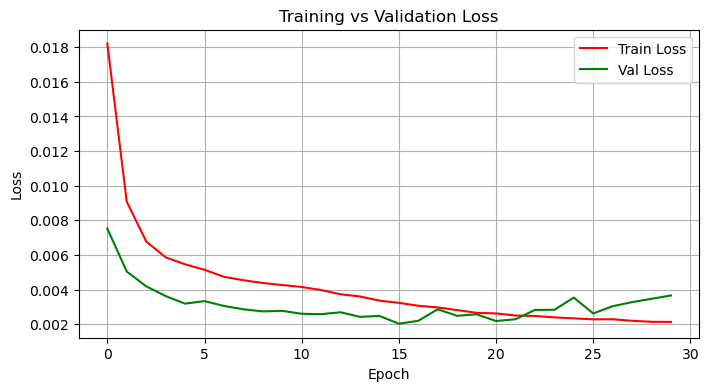

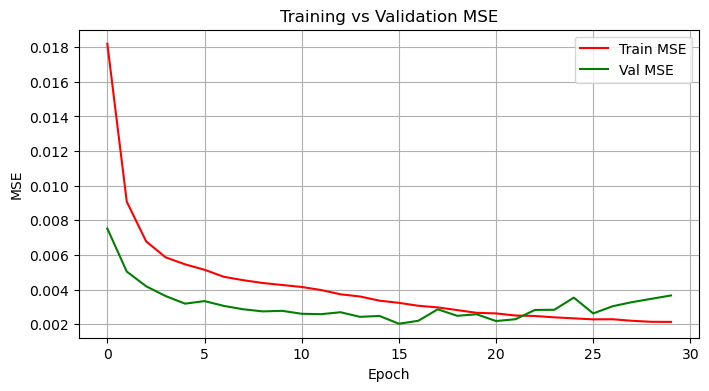

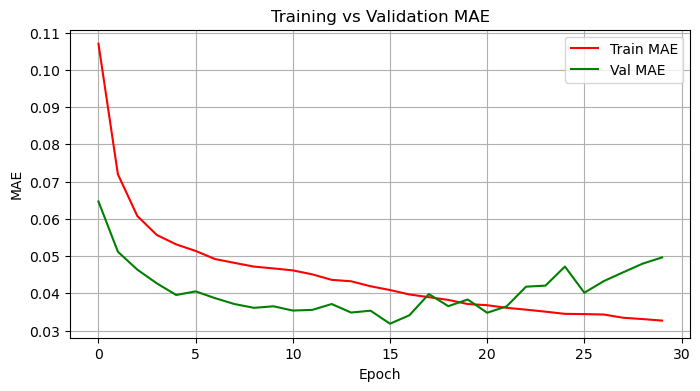

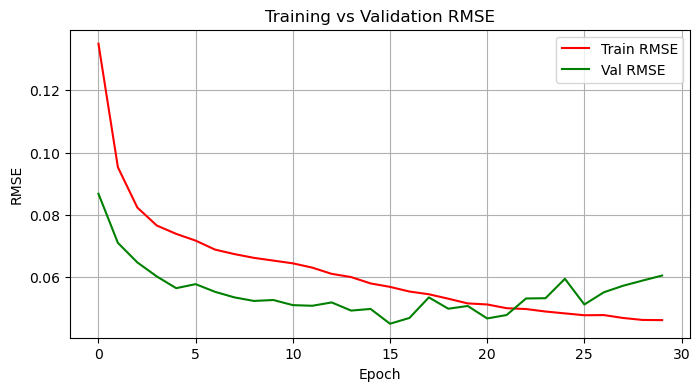

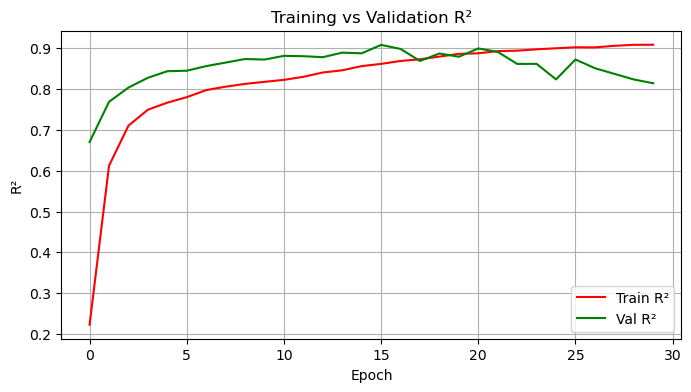

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(conv_train_losses, color = 'red', label='Train Loss')
plt.plot(conv_val_losses, color = 'green', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------------------------------------------

plt.figure(figsize=(8, 4))
plt.plot(conv_train_mse_list, color = 'red', label='Train MSE')
plt.plot(conv_validation_mse_list, color = 'green', label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training vs Validation MSE')
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------------------------------------------

plt.figure(figsize=(8, 4))
plt.plot(conv_train_mae_list, color = 'red', label='Train MAE')
plt.plot(conv_validation_mae_list, color = 'green', label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------------------------------------------

plt.figure(figsize=(8, 4))
plt.plot(conv_train_rmse_list, color = 'red', label='Train RMSE')
plt.plot(conv_validation_rmse_list, color = 'green', label='Val RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training vs Validation RMSE')
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------------------------------------------

plt.figure(figsize=(8, 4))
plt.plot(conv_train_r2_list, color = 'red', label='Train R²')
plt.plot(conv_validation_r2_list, color = 'green', label='Val R²')
plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Training vs Validation R²')
plt.legend()
plt.grid(True)
plt.show()


3. Plot the distribution of the reconstruction errors (i.e., differences between input and output data points).

The histogram shows that most reconstruction errors are clustered around very small values closed to 0. It  means that the model accurately reconstructs the majority of samples. A small number of instances exhibit higher error. But the distribution suggests that the autoencoder is generally effective at minimizing reconstruction errors across the dataset.


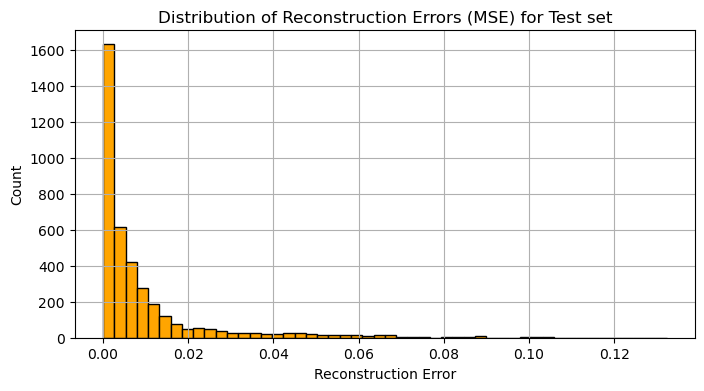

In [ ]:
plt.figure(figsize = (8, 4))
plt.hist(fcn_reconstruction_errors, bins = 50, color = 'orange', edgecolor ='black')
plt.title("Distribution of Reconstruction Errors (MSE) for Test set")
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.grid(True)
plt.show()


4. Discuss and analyze

    - RNN/LSTM architecture in detail -> This architecture is an LSTM based autoencoder that accepts time series data in the form of batch_size, sequence_length, input_size and encodes it into a compact latent representation. The encoder consists of one or more LSTM layers determined by the num_layers parameter, and utilizes a specified hidden size to capture characteristics of the input. It transforms the input sequence into a latent vector by summarizing the temporal information. The decoder reconstructs the original sequence by initializing another LSTM with the encoder’s hidden and cell states. Finally a linear layer deliver the decoder outputs back to the original input dimension.

    - Insights for the results, the metrics and visualization -> When using the 1D Convolutional Autoencoder architecture, I generally achieve an RSQUARE value above 0.85. The evaluation metric graphs also show that various loss related metrics converge to lower values as the epochs progress. The challenging parts were selecting the appropriate activation functions and designing the structures for the encoder and decoder. Additionally, tuning the learning rate and using the Adam optimizer helped improve performance.


    - The strengths and limitations of using autoencoders for anomaly detection -> In terms of strengths, Autoencoders are particularly useful for anomaly detection because it operate in an unsupervised manner and learns patterns directly from unlabeled data. It can also capture complex, high-dimensional relationships in the input which can lead to make the architecture more powerful than simpler statistical methods. Moreover, This model can be tailored to various data types like images, time series, or tabular data by adjusting the network architecture. On the other hand, a challenge is selecting an appropriate reconstruction error threshold for classifying anomalies when labeled data is limited. If the autoencoder overfits the training set, it may ineffectively learn to reconstruct anomalous points. The ability to detect them can be diminished. Additionally, autoencoders assume that most of the data is normal, so a large proportion of anomalies can disrupt the ability to learn a robust representation of normal patterns.
    

5. References. Include details on all the resources used to complete this part, e.g. links to datasets, research papers or articles, code examples or tutorials you referred.

    - Autoencoders from IBM Technology (https://www.youtube.com/watch?v=qiUEgSCyY5o&ab_channel=IBMTechnology)
    - Variational Autoencoders from Arxiv Insights (https://www.youtube.com/watch?v=9zKuYvjFFS8&ab_channel=ArxivInsights)
    - Autoencoder from DeepLearning AI (https://www.deeplearning.ai/the-batch/one-network-many-scenes/)
    - Autoencoder from Wikipedia (https://en.wikipedia.org/wiki/Autoencoder)
    - Implementing an Autoencoder in PyTorch from Geeksforgeeks (https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/)
    - CSE 676B

6. A contribution summary.



    | Team Member | Step# | Contribution (%) |
    |-------------|---|---|
    | Seokwoo Park|Step 1 |   50             |
    | Apoorv  Sood|Step 1 |   50             |
    | Seokwoo Park|Step 2 |   50             |
    | Apoorv  Sood|Step 2 |   50             |
    | Seokwoo Park|Step 3 |   50             |
    | Apoorv  Sood|Step 3 |   50             |